# Preprocessing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os,gzip
from scipy import signal
import pandas as pd
from tqdm import tqdm

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## **Formating Files** ##

Formatting Files in to Numpy lists

Finding matching Thresholds

In [2]:
start_position=0
end_position=80
mtx_list = [x for x in os.listdir() if x.endswith('.npy.gz')][start_position:end_position]
thresholds=[]

img_list=[]
mtx_no_th=[]
#Check threshold file
if os.path.exists('threshold.csv'):
    df = pd.read_csv('threshold.csv')
else:
    raise ValueError('No threshold.csv file')

for i in tqdm(range(len(mtx_list))):
    mtx_name=mtx_list[i]
    if mtx_name in df.name.values:
        if df[df.name.values==mtx_name].threshold.item()>0:
            with gzip.GzipFile(mtx_name, 'rb') as f:
                mtx=np.load(f)
                kernel = np.outer(signal.windows.gaussian(100, 25),
                          signal.windows.gaussian(100, 25))
                convolv_matrix = signal.fftconvolve(mtx, kernel, mode='same')
                convolv_matrix = convolv_matrix / convolv_matrix.max()
                convolv_matrix[convolv_matrix<0]=0 # assign 0 to value smaller than 0
                img_list.append(convolv_matrix)
                thresholds.append(df[df.name.values==mtx_name].threshold.item())
    else: 
            mtx_no_th.append(mtx_name)  

mtx_with_th = [x for x in mtx_list if x not in mtx_no_th]

print(str(len(mtx_with_th))+' matrix have Threshold')
print(str(len(mtx_no_th))+' matrix have no Threshold')
print('Check mtx_no_th for detailed list of matrix unlabeled')

# Change image list to Numpy
images=np.stack(img_list)

# Getting thresholds
thresholds=np.array(thresholds)
print(thresholds.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 80/80 [02:01<00:00,  1.52s/it]


80 matrix have Threshold
0 matrix have no Threshold
Check mtx_no_th for detailed list of matrix unlabeled
(78,)


## **Threshold Sanity Check** ##


In [3]:
#Sanity check
id=66
print(thresholds[id])
print(mtx_with_th[id])
print(thresholds[id]==df[df['name']==mtx_with_th[id]].threshold.values)

0.075
NoEEL_240605_2r-5G_mtx.npy.gz
[ True]


# Model Prep

## **Define Dataset** ##

In [4]:
# Define a custom dataset
class ImageThresholdDataset(Dataset):
    def __init__(self, images, thresholds):
        self.images = images
        self.thresholds = thresholds
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        threshold = self.thresholds[idx]
        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(threshold, dtype=torch.float32)


## **Define Model (Basic CNN)** ##

In [5]:

# Define the CNN model
class ThresholdPredictorCNN(nn.Module):
    def __init__(self):
        super(ThresholdPredictorCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4) ## Just to speed up, harsh pooling 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3= nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(128 * (images.shape[1] // 64) * (images.shape[2] // 64), 64)
        self.fc2 = nn.Linear(64, 1)


    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (images.shape[1] // 64) * (images.shape[2] // 64))
        x = torch.relu(self.fc1(x))
        x =  torch.div(0.5, (1+torch.exp(-self.fc2(x))))
        return x

model = ThresholdPredictorCNN()


In [6]:
class ThresholdLoss(nn.Module):
    def __init__(self):
        super(ThresholdLoss, self).__init__()
        
    def forward(self, y_true, y_pred):
        intersection = torch.sum(y_true * y_pred, dim=[1, 2, 3])
        union = torch.sum(y_true, dim=[1, 2, 3]) + torch.sum(y_pred, dim=[1, 2, 3]) - intersection
        iou = intersection / (union + 1e-6)
        loss = 1 - iou.mean()
        
        return loss

# Train Model


## In case Training stop in the middle: Load model here 

In [ ]:

model.load_state_dict(torch.load('Best_CNNModel_NoNegative.pth'))
# Trained 2 times using reshuffled datasets. 

## Run This Code Block Twice to Shuffle and train for best Model

  0%|                                                                                             | 0/20 [00:00<?, ?it/s]

tensor([[0.1588],
        [0.0824],
        [0.1266],
        [0.2075],
        [0.0716],
        [0.1620],
        [0.1915],
        [0.0758],
        [0.1400],
        [0.1000]], grad_fn=<SliceBackward0>)
tensor([[0.2575],
        [0.2575],
        [0.2575],
        [0.1805],
        [0.2290],
        [0.1746],
        [0.2217],
        [0.1861],
        [0.1758],
        [0.1662]], grad_fn=<SliceBackward0>)


  5%|████                                                                              | 1/20 [05:40<1:47:48, 340.44s/it]

Epoch 1/20, Train Loss: 0.1433, Val Loss: 0.0856
tensor([[0.1055],
        [0.1839],
        [0.1123],
        [0.0927],
        [0.1205],
        [0.1711],
        [0.0449],
        [0.1103],
        [0.1315],
        [0.1596]], grad_fn=<SliceBackward0>)
tensor([[0.1460],
        [0.1123],
        [0.1065],
        [0.0548],
        [0.1137],
        [0.1039],
        [0.1256],
        [0.0748],
        [0.0806],
        [0.0720]], grad_fn=<SliceBackward0>)


 10%|████████▏                                                                         | 2/20 [12:02<1:49:25, 364.77s/it]

Epoch 2/20, Train Loss: 0.0925, Val Loss: 0.1361
tensor([[0.0614],
        [0.0544],
        [0.0815],
        [0.0487],
        [0.0387],
        [0.0955],
        [0.0426],
        [0.0890],
        [0.1045],
        [0.1131]], grad_fn=<SliceBackward0>)
tensor([[0.0940],
        [0.1088],
        [0.0604],
        [0.0447],
        [0.0483],
        [0.0418],
        [0.0666],
        [0.1090],
        [0.0745],
        [0.0525]], grad_fn=<SliceBackward0>)


 15%|████████████▎                                                                     | 3/20 [17:41<1:40:00, 353.00s/it]

Epoch 3/20, Train Loss: 0.1339, Val Loss: 0.1431
tensor([[0.0380],
        [0.1134],
        [0.0792],
        [0.0557],
        [0.1264],
        [0.0598],
        [0.0778],
        [0.0353],
        [0.1142],
        [0.0578]], grad_fn=<SliceBackward0>)
tensor([[0.0901],
        [0.0630],
        [0.1424],
        [0.0681],
        [0.0641],
        [0.0484],
        [0.0632],
        [0.1150],
        [0.0466],
        [0.1245]], grad_fn=<SliceBackward0>)


 20%|████████████████▍                                                                 | 4/20 [23:51<1:36:00, 360.01s/it]

Epoch 4/20, Train Loss: 0.1211, Val Loss: 0.0653
tensor([[0.0562],
        [0.0845],
        [0.1174],
        [0.1095],
        [0.0664],
        [0.1071],
        [0.0778],
        [0.1522],
        [0.1078],
        [0.0366]], grad_fn=<SliceBackward0>)
tensor([[0.1273],
        [0.1335],
        [0.2001],
        [0.1444],
        [0.0996],
        [0.1020],
        [0.1779],
        [0.1799],
        [0.0645],
        [0.2108]], grad_fn=<SliceBackward0>)


 25%|████████████████████▌                                                             | 5/20 [29:38<1:28:46, 355.08s/it]

Epoch 5/20, Train Loss: 0.0504, Val Loss: 0.0663
tensor([[0.1199],
        [0.2004],
        [0.2167],
        [0.1112],
        [0.1257],
        [0.1233],
        [0.2179],
        [0.1831],
        [0.1554],
        [0.1279]], grad_fn=<SliceBackward0>)
tensor([[0.1268],
        [0.1487],
        [0.1768],
        [0.1264],
        [0.1245],
        [0.0930],
        [0.1802],
        [0.1038],
        [0.1736],
        [0.1544]], grad_fn=<SliceBackward0>)


 30%|████████████████████████▌                                                         | 6/20 [35:20<1:21:48, 350.58s/it]

Epoch 6/20, Train Loss: 0.0815, Val Loss: 0.0712
tensor([[0.1730],
        [0.1052],
        [0.1560],
        [0.1124],
        [0.0450],
        [0.2137],
        [0.1216],
        [0.1900],
        [0.1470],
        [0.1131]], grad_fn=<SliceBackward0>)
tensor([[0.1521],
        [0.1134],
        [0.0696],
        [0.0884],
        [0.0799],
        [0.1181],
        [0.1077],
        [0.1407],
        [0.1075],
        [0.1114]], grad_fn=<SliceBackward0>)


 35%|████████████████████████████▋                                                     | 7/20 [40:32<1:13:15, 338.12s/it]

Epoch 7/20, Train Loss: 0.0609, Val Loss: 0.0334
tensor([[0.1612],
        [0.1796],
        [0.0955],
        [0.0880],
        [0.1039],
        [0.1282],
        [0.1139],
        [0.0858],
        [0.0968],
        [0.1491]], grad_fn=<SliceBackward0>)
tensor([[0.1190],
        [0.1094],
        [0.1337],
        [0.1495],
        [0.0657],
        [0.0813],
        [0.0998],
        [0.0811],
        [0.0734],
        [0.1026]], grad_fn=<SliceBackward0>)


 40%|████████████████████████████████▊                                                 | 8/20 [45:21<1:04:30, 322.52s/it]

Epoch 8/20, Train Loss: 0.0541, Val Loss: 0.0706
tensor([[0.0772],
        [0.0755],
        [0.0901],
        [0.0865],
        [0.0784],
        [0.0575],
        [0.1046],
        [0.0749],
        [0.1276],
        [0.1577]], grad_fn=<SliceBackward0>)
tensor([[0.1475],
        [0.0632],
        [0.0606],
        [0.0619],
        [0.0987],
        [0.1053],
        [0.1043],
        [0.1279],
        [0.1236],
        [0.0704]], grad_fn=<SliceBackward0>)


 45%|█████████████████████████████████████▊                                              | 9/20 [50:13<57:21, 312.89s/it]

Epoch 9/20, Train Loss: 0.0716, Val Loss: 0.0544
tensor([[0.1539],
        [0.1630],
        [0.0877],
        [0.0293],
        [0.0958],
        [0.0840],
        [0.1290],
        [0.0735],
        [0.0602],
        [0.1107]], grad_fn=<SliceBackward0>)
tensor([[0.0726],
        [0.1613],
        [0.1411],
        [0.1025],
        [0.1877],
        [0.0840],
        [0.0869],
        [0.0939],
        [0.1123],
        [0.0555]], grad_fn=<SliceBackward0>)


 50%|█████████████████████████████████████████▌                                         | 10/20 [54:59<50:47, 304.72s/it]

Epoch 10/20, Train Loss: 0.0516, Val Loss: 0.0347
tensor([[0.1335],
        [0.1016],
        [0.1383],
        [0.1323],
        [0.1741],
        [0.1010],
        [0.1073],
        [0.1160],
        [0.1571],
        [0.1694]], grad_fn=<SliceBackward0>)
tensor([[0.1036],
        [0.1594],
        [0.1024],
        [0.1142],
        [0.1054],
        [0.1263],
        [0.1853],
        [0.1355],
        [0.1243],
        [0.1068]], grad_fn=<SliceBackward0>)


 55%|█████████████████████████████████████████████▋                                     | 11/20 [59:49<44:59, 299.97s/it]

Epoch 11/20, Train Loss: 0.0432, Val Loss: 0.0546
tensor([[0.1651],
        [0.0436],
        [0.1459],
        [0.1537],
        [0.0967],
        [0.1293],
        [0.1628],
        [0.1495],
        [0.1661],
        [0.1169]], grad_fn=<SliceBackward0>)
tensor([[0.1115],
        [0.1026],
        [0.1479],
        [0.1001],
        [0.1936],
        [0.1159],
        [0.1915],
        [0.2016],
        [0.1373],
        [0.0977]], grad_fn=<SliceBackward0>)


 60%|████████████████████████████████████████████████▌                                | 12/20 [1:04:34<39:23, 295.43s/it]

Epoch 12/20, Train Loss: 0.0579, Val Loss: 0.0334
tensor([[0.1066],
        [0.0754],
        [0.1234],
        [0.1013],
        [0.1211],
        [0.1055],
        [0.1408],
        [0.2170],
        [0.1513],
        [0.0813]], grad_fn=<SliceBackward0>)
tensor([[0.0856],
        [0.1454],
        [0.0949],
        [0.0877],
        [0.1457],
        [0.1698],
        [0.0971],
        [0.1703],
        [0.0906],
        [0.0973]], grad_fn=<SliceBackward0>)


 65%|████████████████████████████████████████████████████▋                            | 13/20 [1:09:31<34:31, 295.90s/it]

Epoch 13/20, Train Loss: 0.0400, Val Loss: 0.0344
tensor([[0.0849],
        [0.0898],
        [0.1058],
        [0.0920],
        [0.0847],
        [0.1717],
        [0.0945],
        [0.1045],
        [0.1132],
        [0.0705]], grad_fn=<SliceBackward0>)
tensor([[0.0888],
        [0.0914],
        [0.0684],
        [0.1158],
        [0.1044],
        [0.0420],
        [0.1302],
        [0.1365],
        [0.1197],
        [0.1599]], grad_fn=<SliceBackward0>)


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [1:14:18<29:19, 293.31s/it]

Epoch 14/20, Train Loss: 0.0435, Val Loss: 0.0351
tensor([[0.0619],
        [0.1177],
        [0.0906],
        [0.2025],
        [0.0895],
        [0.0657],
        [0.1394],
        [0.1225],
        [0.0890],
        [0.0839]], grad_fn=<SliceBackward0>)
tensor([[0.1462],
        [0.1194],
        [0.1936],
        [0.0961],
        [0.1300],
        [0.1267],
        [0.0891],
        [0.0518],
        [0.0964],
        [0.1733]], grad_fn=<SliceBackward0>)


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [1:19:05<24:16, 291.32s/it]

Epoch 15/20, Train Loss: 0.0383, Val Loss: 0.0209
tensor([[0.1886],
        [0.1548],
        [0.0701],
        [0.1048],
        [0.0822],
        [0.0330],
        [0.0955],
        [0.1001],
        [0.0652],
        [0.1198]], grad_fn=<SliceBackward0>)
tensor([[0.0781],
        [0.1631],
        [0.1329],
        [0.1304],
        [0.1470],
        [0.1237],
        [0.0697],
        [0.1432],
        [0.1084],
        [0.2343]], grad_fn=<SliceBackward0>)


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [1:23:54<19:22, 290.63s/it]

Epoch 16/20, Train Loss: 0.0317, Val Loss: 0.0338
tensor([[0.1923],
        [0.1037],
        [0.1559],
        [0.1460],
        [0.2218],
        [0.0794],
        [0.0896],
        [0.1965],
        [0.0988],
        [0.1591]], grad_fn=<SliceBackward0>)
tensor([[0.1433],
        [0.0497],
        [0.1288],
        [0.1312],
        [0.1037],
        [0.1234],
        [0.1077],
        [0.0981],
        [0.1339],
        [0.1893]], grad_fn=<SliceBackward0>)


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [1:28:43<14:30, 290.28s/it]

Epoch 17/20, Train Loss: 0.0360, Val Loss: 0.0205
tensor([[0.0975],
        [0.0744],
        [0.1305],
        [0.0928],
        [0.0992],
        [0.1797],
        [0.0630],
        [0.0990],
        [0.0766],
        [0.1237]], grad_fn=<SliceBackward0>)
tensor([[0.1696],
        [0.1278],
        [0.1381],
        [0.1534],
        [0.1085],
        [0.1825],
        [0.1183],
        [0.2179],
        [0.0843],
        [0.1383]], grad_fn=<SliceBackward0>)


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [1:33:27<09:36, 288.25s/it]

Epoch 18/20, Train Loss: 0.0302, Val Loss: 0.0282
tensor([[0.0951],
        [0.1685],
        [0.0946],
        [0.1535],
        [0.1746],
        [0.1536],
        [0.0656],
        [0.1837],
        [0.1285],
        [0.0839]], grad_fn=<SliceBackward0>)
tensor([[0.0612],
        [0.1234],
        [0.0866],
        [0.1254],
        [0.1424],
        [0.1284],
        [0.0645],
        [0.1746],
        [0.0895],
        [0.0966]], grad_fn=<SliceBackward0>)


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [1:38:15<04:48, 288.16s/it]

Epoch 19/20, Train Loss: 0.0300, Val Loss: 0.0176
tensor([[0.1246],
        [0.1205],
        [0.1363],
        [0.1325],
        [0.1874],
        [0.0905],
        [0.1980],
        [0.1850],
        [0.0817],
        [0.1149]], grad_fn=<SliceBackward0>)
tensor([[0.1030],
        [0.1700],
        [0.0824],
        [0.1249],
        [0.1692],
        [0.2335],
        [0.1047],
        [0.1266],
        [0.1565],
        [0.0868]], grad_fn=<SliceBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [1:43:01<00:00, 309.07s/it]

Epoch 20/20, Train Loss: 0.0238, Val Loss: 0.0202


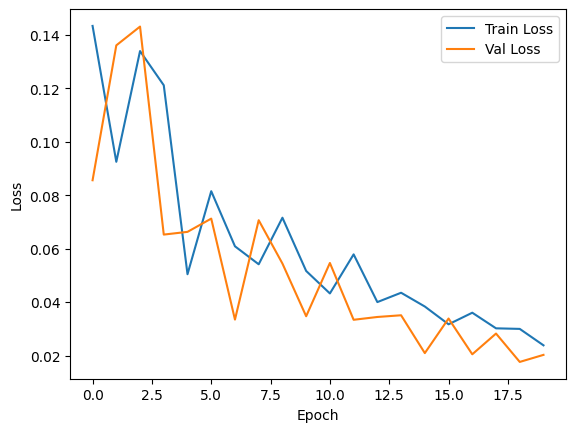

In [9]:
# Create dataset and data loaders
dataset = ImageThresholdDataset(images,thresholds)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=35, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=35, shuffle=False)

# Define the loss function and optimizer
criterion = ThresholdLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model
num_epochs = 20 ## faster
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for X, Y in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        print(outputs[0:10])
        msk_true=(X>Y.view(-1,1,1,1)).float()
        msk_pred=nn.Sigmoid()((X-outputs.view(-1,1,1,1))*1e6)
        loss = criterion(msk_true,msk_pred)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, Y in val_loader:
            outputs = model(X)
            msk_true=(X>Y.view(-1,1,1,1)).float()
            msk_pred=nn.Sigmoid()((X-outputs.view(-1,1,1,1))*1e6)
            loss = criterion(msk_true,msk_pred)
            val_loss += loss.item() * X.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Best_CNNModel_NoNegative.pth') #Saving the model
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot training history
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
